# Demonstrate the violation of the CHSH inequality with the Estimator primitive

In this tutorial, you will run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive. 

The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics. Demonstrating this on a quantum computer was a major scientific breakthrough worthy of a high impact journal publication just a few years ago. [citation] It's truly incredible that you can conduct this experiment at the comfort of your home using Qiskit and an IBM Quantum system.

## Before you begin

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, follow the instructions in the Qiskit [Getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background Information

### CHSH Inequality

The CHSH inequality, named after the authors Clauser, Horne, Shimony, and Holt, is used to experimentally prove Bell's theorem.  This theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. 

For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit $A$ and $a$ and the bases for the second qubit $B$ and $b$.  This allows us to compute the CHSH quantity $S_1$:

$$S_1 = A(B-b) + a(B+b).$$

Each observable is either $+1$ or $-1$. Clearly, one of the terms $B\pm b$ must be $0$, and the other must be $\pm 2$.  Therefore, $S_1 = \pm 2$. The average value of $S_1$ must satisfy the inequality:

$$|\langle S_1 \rangle|\leq 2.$$

Expanding $S_1$ in terms of $A$, $a$, $B$, and $b$ results in:

$$|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$$

You can define another CHSH quantity $S_2$:

$$S_2 = A(B+b) - a(B-b),$$

This leads to another inequality:

$$|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2$$

If quantum mechanics can be described by local hidden variable theories, the above inequalities must hold true. However, as you are going to demonstrate in this notebook, these inequalities can be violated in a quantum computer.  Therefore, quantum mechanics is not compatible with local hidden variable theories.

If you want to learn more, you can read the chapter about the CHSH inequality in [the Qiskit textbook](https://qiskit.org/textbook/ch-demos/chsh.html).



## Overview

You will create an entangled pair between two qubits in a quantum computer by creating the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$). Using the Estimator primitive, you can directly obtain the expectation values needed ($\langle AB \rangle, \langle Ab \rangle, \langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities $\langle S_1\rangle$ and $\langle S_2\rangle$. Before the introduction of the Estimator primitive, you would have to construct the expectation values from the measurement outcomes.

You will measure the second qubit in the $Z$ and $X$ bases.  The first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. As you will see, the Estimator primitive makes running parameterized circuits very easy. Instead of creating a series of CHSH circuits, you only need to create *one* CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, you will analyze the results and plot them against the measurement angle. You will see that for certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1\rangle| > 2$ or $|\langle S_2\rangle| > 2$, which demonstrates the violation of the CHSH inequality.

## Step 1: Create CHSH circuits

### Create a parameterized CHSH circuit 

First, we write the circuit with the parameter $\theta$, which we call `theta`. The `Estimator` primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. For maximum generalization, the `Estimator` primitive requires circuits with no measurements.

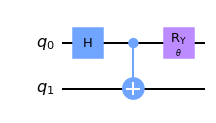

In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('$\\theta$')

chsh_circuits_no_meas = QuantumCircuit(2)
chsh_circuits_no_meas.h(0)
chsh_circuits_no_meas.cx(0, 1)
chsh_circuits_no_meas.ry(theta, 0)
chsh_circuits_no_meas.draw()

### Create a list of phase values to be assigned later

After creating the parameterized CHSH circuit, you will create a list of phase values to be assigned to the circuit in the next step. You can use the code below to create a list of 21 phase values range from $0$ to $2 \pi$ with equal spacing, i.e. $0$, $0.1 \pi$, $0.2 \pi$, ..., $1.9 \pi$, $2 \pi$.

In [2]:
import numpy as np

number_of_phases = 21
phases = np.linspace(0, 2*np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

## Step 2: Submit the circuits to a quantum computer on the cloud



### Connect to the Qiskit Runtime service  

Before running circuits, you need to connect to the Qiskit Runtime service instance that you created in [the first step](#before-you-begin). We will run this tutorial on both a simulator and a real quantum system. The simulator results are generated without noise, while the experimental results on a real quantum system are generated in the presence of noise.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options_sim = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator
options_exp = {'backend_name': 'ibmq_qasm_simulator'}  # use a real quantum system TODO change to a real system later

### Run the parameterized circuits using the Estimator primitive 

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$ rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.

In [4]:
from qiskit_ibm_runtime import Estimator
from qiskit.quantum_info import SparsePauliOp

ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
chsh_est_sim = []
chsh_est_exp = []

# Simulator
with Estimator(circuits=chsh_circuits_no_meas, observables=ops,
                service=service, options=options_sim) as estimator:
    for op in ops:
        est_result = estimator(circuits=[0]*len(individual_phases),
                        observables=[op]*len(individual_phases),
                        parameter_values=individual_phases)
        chsh_est_sim.append(est_result)

# Real device
with Estimator(circuits=chsh_circuits_no_meas, observables=ops,
                service=service, options=options_exp) as estimator:
    for op in ops:
        est_result = estimator(circuits=[0]*len(phases),
                            observables=[op]*len(phases),
                            parameter_values=individual_phases)
        chsh_est_exp.append(est_result)

## Step 3: Analyze the results

After running the circuits, we need to build the CHSH witness functions. We first build the quantities $\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$, by looking at the parity of the outcomes for the four families of circuits we built (two measurement bases for each of the two qubits). Then we use those quantities to build the witness functions as defined above.

In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est_sim = chsh_est_sim[0].values - chsh_est_sim[1].values + chsh_est_sim[2].values + chsh_est_sim[3].values
chsh1_est_exp = chsh_est_exp[0].values - chsh_est_exp[1].values + chsh_est_exp[2].values + chsh_est_exp[3].values

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est_sim = chsh_est_sim[0].values + chsh_est_sim[1].values - chsh_est_sim[2].values + chsh_est_sim[3].values
chsh2_est_exp = chsh_est_exp[0].values + chsh_est_exp[1].values - chsh_est_exp[2].values + chsh_est_exp[3].values

Note that now we do not have to build the observables ourselves because they are returned to us! The computed expectation values are given in `result.values`. What comes back is a very small payload of data.

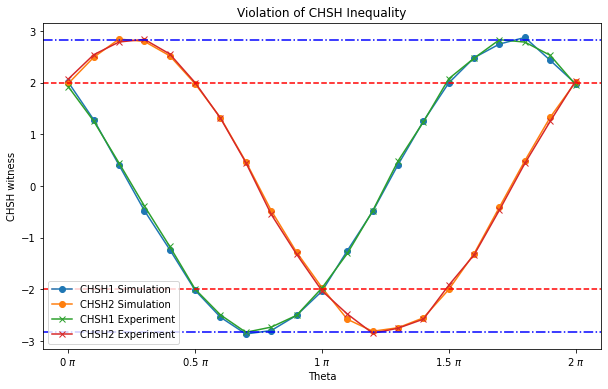

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

fig, ax = plt.subplots(figsize=(10, 6))
# results from a simulator
ax.plot(phases/np.pi, chsh1_est_sim, 'o-', label='CHSH1 Simulation')
ax.plot(phases/np.pi, chsh2_est_sim, 'o-', label='CHSH2 Simulation')
# results from a real quantum system
ax.plot(phases/np.pi, chsh1_est_exp, 'x-', label='CHSH1 Experiment')
ax.plot(phases/np.pi, chsh2_est_exp, 'x-', label='CHSH2 Experiment')
# classical bound +-2
ax.axhline(y=2, color='r', linestyle='--')
ax.axhline(y=-2, color='r', linestyle='--')
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
ax.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# set title, labels, and legend
plt.title('Violation of CHSH Inequality')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()

In the figure above, the red dashed lines delimit the classical bounds ($\pm 2$) and the dash-dotted blue lines delimit the quantum bounds ($\pm 2\sqrt{2}$). You can see that the experimental results resemble the general trend of the simulated results and there are regions where the CHSH witness quantities exceeds the classical bounds. Congratulations! You have successfully demonstrated the violation of CHSH inequality in a real quantum system!

## Summary

In this tutorial, you have created a parameterized CHSH circuit, run it using the Estimator primitive, analyzed the results and demonstrated the violation of CHSH inequality. You can see that the Estimator primitive not only makes running parameterized circuits very easy but also greatly simplifies the workflow for obtaining expectation values for observables.

## References

1. Córcoles, A. (n.d.), Local Reality and the CHSH Inequality. In A. Abbas, et al. Learn Quantum Computation Using Qiskit. URL: https://qiskit.org/textbook/ch-demos/chsh.html (accessed 07/13/2022) (2020).

## Qiskit versions and copyright

In [7]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.1'

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright